# Estimating sandwich bounds on the rate-distortion function of a Gaussian source

This notebook demonstrates the method proposed in 

>  "Towards Empirical Sandwich Bounds on the Rate-Distortion Function"
>
>  Yibo Yang, Stephan Mandt
>
>  [https://arxiv.org/abs/2111.12166](https://arxiv.org/abs/2111.12166)

on a randomly generated 2-dimensional Gaussian distribution.
Also see [blog post](https://yiboyang.com/posts/estimating-the-rate-distortion-function-of-real-world-data-part-1/) for an introduction to the topic.

In [10]:
## Basic setup/imports

In [11]:
import numpy as np
import os
dtype = np.float32

In [12]:
import matplotlib
import matplotlib.pyplot as plt

In [13]:
import utils

In [14]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

seed = 0
tf.random.set_seed(seed)

In [15]:
## We keep lambda fixed throughout the notebook; rerunning with different lamb traces out the full UB/LB
lamb = 3.0

## Create a Gaussian source with a randomly sampled location and scale vector

In [16]:
data_dim = 2
np.random.seed(seed)
loc = np.random.uniform(-0.5, 0.5, data_dim).astype(dtype)
var = np.random.uniform(0, 2, data_dim).astype(dtype)
scale = var ** 0.5
source = tfd.Normal(loc=loc, scale=scale)

In [17]:
samples = source.sample(10)
samples

import torch
pytorch_tensor = torch.zeros(10)
tf_tensor = tf.convert_to_tensor(pytorch_tensor)
tf_tensor

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)>

## Estimate a point on the upper bound of the R-D curve, by training a VAE

In [18]:
args = {
    "encoder_units": [],
    "encoder_activation": None,
    "decoder_units": [
        10
    ],
    "decoder_activation": "leaky_relu",
    "posterior_type": "gaussian",
    "prior_type": "gmm_1",  # factorized Gaussian prior with learned mean and scale
    "maf_stacks": 0,
    "ar_activation": None,

    "batchsize": 64,
    "data_dim": data_dim,
    "latent_dim": data_dim,

    "lmbda": lamb,
    "lr": 5e-4,

    "epochs": 20,
    "seed": 0,
    "steps_per_epoch": 10000,
    "max_validation_steps": 1000,
    "nats": True,
    "rpd": False  # do not scale lambda by the source dimension
}
args = utils.get_args_as_obj(args)

import rdub_mlp
ub_model = rdub_mlp.Model.create_model(args)
ub_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=args.lr),
)


In [19]:
dataset = tf.data.Dataset.from_tensors([])
dataset = dataset.repeat()
dataset = dataset.map(lambda _: source.sample(args.batchsize))

tmp_save_dir = '/tmp/rdvae'
lr_scheduler = rdub_mlp.get_lr_scheduler(args.lr, args.epochs, decay_factor=0.2)
hist = ub_model.fit(
    dataset.prefetch(tf.data.AUTOTUNE),
    epochs=args.epochs,
    steps_per_epoch=args.steps_per_epoch,
    validation_data=None,
    validation_freq=1,
    callbacks=[
        tf.keras.callbacks.TerminateOnNaN(),
        tf.keras.callbacks.experimental.BackupAndRestore(tmp_save_dir),
        tf.keras.callbacks.LearningRateScheduler(lr_scheduler),
    ],
    verbose=True
)
ub_records = hist.history


Epoch 1/20
10000/10000 [==============================] - 17s 2ms/step - loss: 2.5761 - rate: 1.2895 - mse: 0.4289
Epoch 2/20
10000/10000 [==============================] - 16s 2ms/step - loss: 2.2359 - rate: 1.2344 - mse: 0.3338
Epoch 3/20
10000/10000 [==============================] - 17s 2ms/step - loss: 2.2350 - rate: 1.2342 - mse: 0.3336
Epoch 4/20
10000/10000 [==============================] - 16s 2ms/step - loss: 2.2367 - rate: 1.2354 - mse: 0.3338
Epoch 5/20
10000/10000 [==============================] - 16s 2ms/step - loss: 2.2364 - rate: 1.2356 - mse: 0.3336
Epoch 6/20
10000/10000 [==============================] - 16s 2ms/step - loss: 2.2359 - rate: 1.2350 - mse: 0.3336
Epoch 7/20
10000/10000 [==============================] - 16s 2ms/step - loss: 2.2372 - rate: 1.2358 - mse: 0.3338
Epoch 8/20
10000/10000 [==============================] - 15s 1ms/step - loss: 2.2366 - rate: 1.2356 - mse: 0.3336
Epoch 9/20
10000/10000 [==============================] - 16s 2ms/step - loss: 2

In [20]:
ub_records

{'loss': [2.576111078262329,
  2.235882043838501,
  2.2349860668182373,
  2.2366602420806885,
  2.236415147781372,
  2.2359070777893066,
  2.2371532917022705,
  2.236572265625,
  2.2347590923309326,
  2.2367348670959473,
  2.237233877182007,
  2.236157178878784,
  2.23508620262146,
  2.2359819412231445,
  2.23557710647583,
  2.2347617149353027,
  2.237445592880249,
  2.2337286472320557,
  2.233992099761963,
  2.235262870788574],
 'rate': [1.2894731760025024,
  1.2343525886535645,
  1.23417329788208,
  1.2353605031967163,
  1.235558032989502,
  1.2349655628204346,
  1.2358012199401855,
  1.2356168031692505,
  1.2339178323745728,
  1.2357481718063354,
  1.2366485595703125,
  1.2366405725479126,
  1.2345198392868042,
  1.235187292098999,
  1.2355722188949585,
  1.2351301908493042,
  1.2360390424728394,
  1.2357447147369385,
  1.2347981929779053,
  1.2332197427749634],
 'mse': [0.4288800358772278,
  0.33384326100349426,
  0.3336050510406494,
  0.33376768231391907,
  0.333617627620697,
  0.

## Estimate a point on the R-D curve by running Blahut-Arimoto on the discretized source

In [21]:
N = 100000
samples = source.sample(N).numpy()
bins = 50

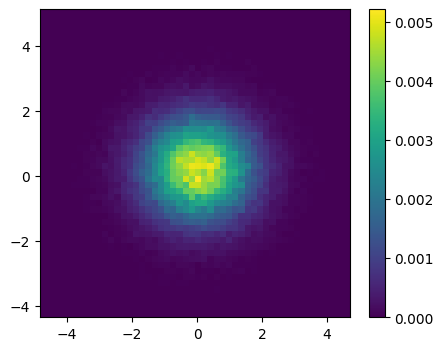

In [22]:
## Plot the discretized source
fig, ax = plt.subplots(figsize=(5, 4))
h = ax.hist2d(samples[:, 0], samples[:, 1], bins=bins, cmap='viridis', weights=np.ones(N) / N) # plot freq: https://stackoverflow.com/a/16399202
fig.colorbar(h[3], ax=ax)

In [23]:
## Get the PMF of the discretized source, and set up the discretized alphabets
from ba import bin_edges_to_grid_pts, vectorized_mse, blahut_arimoto

n = samples.shape[1]
hist_res = np.histogramdd(samples, bins=bins)  # , range=(xlim, ylim))
counts = hist_res[0]  # joint counts
bin_edges = hist_res[1]  # length-n list of arrays, each array has length bins+1

grid_axes = [bin_edges_to_grid_pts(edges) for edges in bin_edges]

# Enumerate grid points corresponding to the histogram (using the center of each bin).
meshgrid = np.meshgrid(*grid_axes, indexing='ij')  # length-n list, one 'mesh' for each data dimension
grid_pts = np.dstack(meshgrid)  # each grid point (n-tuple) resides in the inner-most dimension
grid_pts_flat = np.reshape(grid_pts, [-1, n])  # preserve the inner-most dim while flatten the rest
counts_flat = counts.ravel()


good_pts_ind = (counts_flat != 0)
src_alphabet = grid_pts_flat[good_pts_ind]  # remove bins with zero samples from the source alphabet
src_dist = counts_flat[good_pts_ind]
src_dist /= src_dist.sum()

rep_alphabet = grid_pts_flat  # use all bins from the histogram for the reproduction alphabet
Rho = vectorized_mse(src_alphabet, rep_alphabet)


In [24]:
ba_records, log_Q, log_q_y = blahut_arimoto(Rho=Rho, p_x=src_dist, steps=100, lamb=lamb, verbose=True, tol=1e-6)

{'step': 0, 'ub': 3.763377788026208, 'D': 0.3332009510057141, 'R': 2.763774935009066}
{'step': 10, 'ub': 2.231060581542579, 'D': 0.33319778723987126, 'R': 1.2314672198229648}
{'step': 20, 'ub': 2.2310131027425886, 'D': 0.3332340883451089, 'R': 1.231310837707262}
{'step': 30, 'ub': 2.230985391989009, 'D': 0.3332207241567573, 'R': 1.2313232195187367}
Tolerance reached, terminating after 31 steps
{'step': 31, 'ub': 2.230983162998942, 'D': 0.3332196497447839, 'R': 1.2313242137645903}


## Estimate a linear lower bound of the R-D curve, by training a neural network "-log u" function

In [25]:
from nn_models import make_mlp
lb_model = make_mlp(units=[20, 10, 1], activation='selu', name='mlp', input_shape=[data_dim])

In [26]:
def train_lb(log_u_model, nn_optimizer, train_dataset_iter, args):
    # Simplified version of rdlb.train
    records = []
    from rdlb import optimize_y, compute_Ckobj
    M = args.num_Ck_samples
    log_M = np.log(float(M))

    for step in range(-1, args.last_step):
        # Run M many global optimization runs to draw M samples of C_k, in order to estimate the training objective
        opt_ys = []
        log_Ck_samples = []
        x_M_batch = []  # a batch containing M minibatches of data samples, each minibatch consisting of k samples
        for j in range(M):  # embarrassingly parallelizable
            x = next(train_dataset_iter)
            x_M_batch.append(x)

            res = optimize_y(log_u_fun=log_u_model, x=x, lamb=args.lamb, num_steps=args.y_steps,
                             lr=args.y_lr, tol=args.y_tol, init=args.y_init,
                             quick_topn=args.y_quick_topn, verbose=False, chunksize=args.chunksize)
            opt_y = res['opt_y']
            opt_ys.append(opt_y)
            log_Ck_samples.append(res['opt_log_supobj'])

        if step == -1:  # the initial run is just to set the log expansion point alpha
            # 'log_avg_Ck' here is just the avg of the M samples of Ck in log domain, for numerical reasons
            # (and as a R.V., its expected value underestimates the true log E[C_k], just like in IWAE)
            log_avg_Ck = tf.reduce_logsumexp(log_Ck_samples) - log_M
            log_alpha = prev_log_avg_Ck = log_avg_Ck  # for next iter
            continue

        # Update log_alpha for next iter
        beta = args.beta  # should be in [0, 1)
        if abs(prev_log_avg_Ck - log_alpha) <= 10.0:  # heuristic, skips update if the new value would be too extreme
            if beta == 0:
                log_alpha = prev_log_avg_Ck
            else:  # retain beta fraction of its current value, and update alpha with (1-beta) fraction of prev_log_Ck
                # alpha = beta * alpha + (1-beta) * prev E[C_k]
                log_alpha = tf.reduce_logsumexp(
                    [log_alpha + tf.math.log(beta), prev_log_avg_Ck + tf.math.log(1 - beta)])
                
        # Estimate the RD LB objective and do gradient update
        with tf.GradientTape() as tape:
            log_Ck_samples = []
            log_us = []
            for j in tf.range(M):
                x = x_M_batch[j]
                opt_y = opt_ys[j]
                log_Ck, log_u = compute_Ckobj(log_u_fun=log_u_model, x=x, y=opt_y, lamb=lamb)
                log_Ck_samples.append(log_Ck)
                log_us.append(log_u)  # each is a length k tensor

            log_avg_Ck = tf.reduce_logsumexp(log_Ck_samples) - log_M
            log_us = tf.concat(log_us, axis=0)
            E_log_u = tf.reduce_mean(log_us)
            log_E_Ck_est = tf.math.exp(
                log_avg_Ck - log_alpha) + log_alpha - 1  # overestimator of log(E[C_k]) by linearization
            loss = E_log_u + log_E_Ck_est

        prev_log_avg_Ck = log_avg_Ck  # for next iter
        trainable_vars = log_u_model.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        nn_optimizer.apply_gradients(zip(grads, trainable_vars))
        step_rcd = dict(log_alpha=log_alpha, log_avg_Ck=log_avg_Ck, E_log_u=E_log_u,
                        log_E_Ck_est=log_E_Ck_est, loss=loss)

        print_to_console = (10 * step) % args.last_step == 0
        if print_to_console:
            str_to_print = f"step {step}:\t\tloss = {loss:.4g}, log_alpha = {log_alpha:.4g}, log_avg_Ck = {log_avg_Ck:.4g}, log_E_Ck_est = {log_E_Ck_est:.4g}, "
            str_to_print += f"E_log_u = {E_log_u:.4}"
            print(str_to_print)
        step_rcd['step'] = step

        records.append(step_rcd)

        finished = (step + 1 >= args.last_step)
        if finished:
            break
        
    return records

In [27]:
k = 1024
M = 2

In [28]:
args = {
    "data_dim": data_dim,
    "lamb": lamb,
    "batchsize": k,
    "num_Ck_samples": M,

    # for the global optimization inner loop
    "y_init": "quick",
    "y_quick_topn": 3,
    "y_steps": 1000,
    "y_tol": 1e-6,
    "y_lr": 0.01,
    "chunksize": None,

    "lr": 5e-4,
    "last_step": 400,
    "beta": 0.2,
}

args = utils.get_args_as_obj(args)

In [29]:
nn_optimizer = tf.keras.optimizers.Adam(learning_rate=args.lr)

In [30]:
dataset = tf.data.Dataset.from_tensors([])
dataset = dataset.repeat()
dataset = dataset.map(lambda _: source.sample(args.batchsize))

lb_records = train_lb(lb_model, nn_optimizer, iter(dataset), args)

step 0:		loss = -1.392, log_alpha = -1.301, log_avg_Ck = -1.29, log_E_Ck_est = -1.29, E_log_u = -0.1019
step 40:		loss = -1.51, log_alpha = -1.462, log_avg_Ck = -1.481, log_E_Ck_est = -1.481, E_log_u = -0.02883
step 80:		loss = -1.573, log_alpha = -1.582, log_avg_Ck = -1.621, log_E_Ck_est = -1.62, E_log_u = 0.04694
step 120:		loss = -1.58, log_alpha = -1.683, log_avg_Ck = -1.7, log_E_Ck_est = -1.699, E_log_u = 0.1197
step 160:		loss = -1.59, log_alpha = -1.809, log_avg_Ck = -1.804, log_E_Ck_est = -1.804, E_log_u = 0.2145
step 200:		loss = -1.63, log_alpha = -1.967, log_avg_Ck = -1.946, log_E_Ck_est = -1.946, E_log_u = 0.3163
step 240:		loss = -1.686, log_alpha = -2.094, log_avg_Ck = -2.094, log_E_Ck_est = -2.094, E_log_u = 0.4081
step 280:		loss = -1.683, log_alpha = -2.22, log_avg_Ck = -2.194, log_E_Ck_est = -2.194, E_log_u = 0.5111
step 320:		loss = -1.774, log_alpha = -2.36, log_avg_Ck = -2.407, log_E_Ck_est = -2.405, E_log_u = 0.6317
step 360:		loss = -1.777, log_alpha = -2.504, lo

In [31]:
## Run full global optimization procedure to obtain final estimate of the lower bound intercept
# (takes a while; can be parallelized)
from rdlb import est_R_
from copy import copy
test_args = copy(args)
test_args.y_init = 'exhaustive'
test_args.verbose = False
lb_result = est_R_(lb_model, lamb, iter(dataset), test_args)

## Compare the results with the ground-truth R-D function

Text(0, 0.5, 'Rate (nats per sample)')

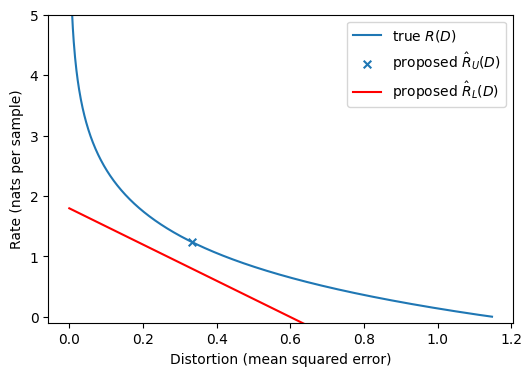

In [40]:
figsize = (6, 4)
fig = plt.figure(figsize=figsize)

gDs, gRs = utils.diag_gaussian_rdf(var, num_points=1000)
plt.plot(gDs, gRs, label='true $R(D)$')

results = {}
results['proposed $\\hat R_U(D)$'] = {'R': ub_records['rate'][-1], 'D': ub_records['mse'][-1]}
# results['Blahut-Arimoto $\\hat R(D)$'] = {'R': ba_records[-1]['R'], 'D': ba_records[-1]['D']}
results['proposed $\\hat R_L(D)$'] = {'lamb': lamb, 'R_': float(lb_result['R_'])}

# plot point on the upper bound
for key, res in results.items():
    if key == 'proposed $\\hat R_L(D)$':
        xs = np.linspace(0, 0.8, 100)
        y = -res['lamb'] * xs + res['R_']  # nats
        plt.plot(xs, y, label=key, color='red')
        pass
    else:
        plt.scatter(res['D'], res['R'], label=key, s=30, marker='x')

# plt.xlim(0, 0.6)
plt.ylim(-0.1, 5)

plt.legend()
plt.xlabel('Distortion (mean squared error)')
plt.ylabel('Rate (nats per sample)')

In [33]:
print(results)

{'proposed $\\hat R_U(D)$': {'R': 1.2332197427749634, 'D': 0.3340151906013489}, 'Blahut-Arimoto $\\hat R(D)$': {'R': 1.2313242137645903, 'D': 0.3332196497447839}, 'proposed $\\hat R_L(D)$': {'lamb': 3.0, 'R_': 1.7945382595062256}}


In [34]:
# The points from the proposed upper bound and BA are visually indistinguishable on the plot.